In [11]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import gym
import os

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
class RolloutVaeDataset(torch.utils.data.Dataset):
    def __init__(self, dir_path, transform=None):
        super(RolloutVaeDataset, self).__init__()

        self.transform = transform

        self.data = []
        if (dir_path[-1] != '/'):
            dir_path += '/'
        for file in os.listdir(dir_path):
          file_np = np.load(dir_path + str(file))
          imgs = file_np['obs'] # 1000 x 64 x 64 x 3
          for curr_img in imgs:
            self.data.append(curr_img)

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        # TODO
        if (self.transform):
          return self.transform(self.data[idx])
        else:
          return torch.tensor(self.data[idx])

In [14]:
# References
# Main VAE Framework: https://github.com/ctallec/world-models
# Loss function and reparameterize: https://github.com/pytorch/examples/tree/master/vae
class VAE(nn.Module):
    def __init__(self, device, beta, batch_size=250):
        super(VAE, self).__init__()

        self.device = device
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2),
            nn.ReLU()
        )

        self.beta = beta
        
        self.mufc = nn.Linear(1024, 32)
        self.logvarfc = nn.Linear(1024, 32)
        
        self.decoder_fc = nn.Linear(32, 1024)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 128, 5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 6, stride=2),
            nn.Sigmoid(),
        )
        
        self.batch_size = batch_size
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)
        return mu + std * noise # z
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(-1, 1024)
        mu, logvar = self.mufc(x), self.logvarfc(x)
        z = self.reparameterize(mu, logvar)
        z_ = self.decoder_fc(z)
        z_ = z_.reshape(-1, 1024, 1, 1)
        return self.decoder(z_.float()), mu, logvar
    
    def get_z(self, x):
        with torch.no_grad():
            encoded = self.encoder(x)
            return self.reparameterize(encoded)

    def loss_func(self, x, x_prime, mu, logvar):
      recon_loss = nn.BCELoss(reduction='sum')
      r_loss = recon_loss(x_prime, x)
      kl_loss = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))) * self.beta
      return r_loss, kl_loss

      return loss

In [16]:
def initialize_weights(layer):
    with torch.no_grad():
        if type(layer) == nn.Linear:
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.01)
        if type(layer) == nn.Conv2d:
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.01)
        if type(layer) == nn.ConvTranspose2d:
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.01)

In [17]:
def plot_loss(losses, title, yLabel, saveFig=False, figSize=(15, 10)):
    sns.set()
    fig = plt.figure(figsize=figSize)
    ax = plt.gca()
    ax.plot(losses)
    ax.set_ylabel(yLabel)
    ax.set_xlabel('Epoch')
    plt.title(title)
    plt.show()

In [18]:
LR = 1e-3
BATCH_SIZE = 1000
USE_CUDA = True
BETAS = (0.9, 0.999) # default adam betas

use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
NUM_WORKERS = multiprocessing.cpu_count()
print('num workers:', NUM_WORKERS)
BETA = 8

Using device cpu
num workers: 2


In [ ]:
path = '/content/drive/MyDrive/env_rollouts/'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), 
                                             torchvision.transforms.Resize((64, 64)), 
                                             torchvision.transforms.ToTensor()])
data_train = RolloutVaeDataset(path, transforms)
trainloader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,shuffle=True)

vae = VAE(device, beta=BETA, batch_size=BATCH_SIZE)
vae.to(device)

optim = torch.optim.Adam(vae.parameters(), lr=LR)
vae.apply(initialize_weights) 
recon_losses = []
kl_losses = []

In [ ]:
NUM_EPOCHS = 20

In [ ]:
for epoch in range(NUM_EPOCHS):
    print('epoch: ' + str(epoch))

    epoch_recons = []
    epoch_kls = []
    for i, data in enumerate(trainloader, 0):
        X_batch = data.to(device, dtype=torch.float)
        X_prime, mu, logvar = vae(X_batch)
        recon_loss, kl_loss = vae.loss_func(X_batch, X_prime, mu, logvar)
        total_loss = recon_loss + kl_loss
        optim.zero_grad()
        total_loss.backward()
        optim.step()

        epoch_recons.append(recon_loss.item())
        epoch_kls.append(kl_loss.item())

    epoch_recon = np.mean(epoch_recons)
    epoch_kl = np.mean(epoch_kls)
    print('epoch recon loss: ' + str(epoch_recon))
    print('epoch kl: ' + str(epoch_kl))
    recon_losses.append(epoch_recon)
    kl_losses.append(epoch_kl)

epoch: 0
epoch recon loss: 7805058.869047619
epoch kl: 5132.672445751372
epoch: 1
epoch recon loss: 7604557.327380952
epoch kl: 25670.367117745536
epoch: 2
epoch recon loss: 7458085.035714285
epoch kl: 39768.23695591518
epoch: 3
epoch recon loss: 7427667.047619048
epoch kl: 44027.40720331101
epoch: 4
epoch recon loss: 7412742.172619048
epoch kl: 45736.48830450149
epoch: 5
epoch recon loss: 7404533.130952381
epoch kl: 46406.81622023809
epoch: 6
epoch recon loss: 7398416.0
epoch kl: 46873.143647693454
epoch: 7
epoch recon loss: 7396136.535714285
epoch kl: 47191.42261904762
epoch: 8
epoch recon loss: 7392180.869047619
epoch kl: 47451.80701264881
epoch: 9
epoch recon loss: 7389255.43452381
epoch kl: 47687.110630580355
epoch: 10
epoch recon loss: 7387152.357142857
epoch kl: 47863.151646205355
epoch: 11
epoch recon loss: 7385788.851190476
epoch kl: 47877.578822544645
epoch: 12
epoch recon loss: 7384066.916666667
epoch kl: 48174.15141369047
epoch: 13
epoch recon loss: 7382468.44047619
epoch k

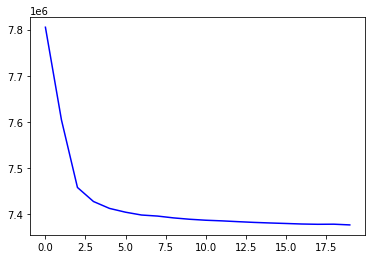

In [ ]:
plt.plot(recon_losses, color='blue')
plt.show()

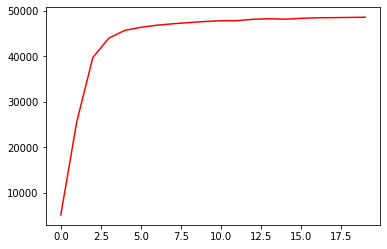

In [ ]:
plt.plot(kl_losses, color='red')
plt.show()

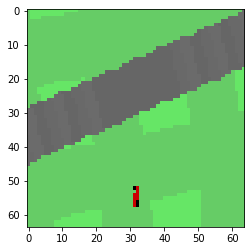

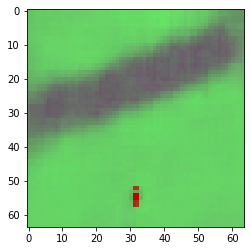

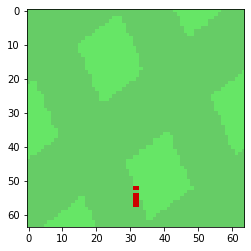

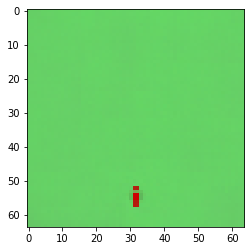

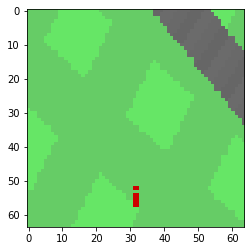

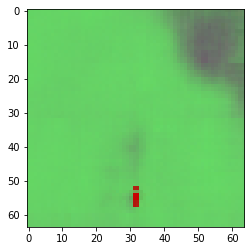

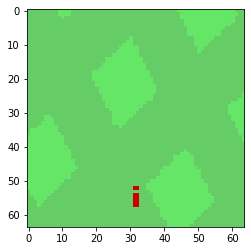

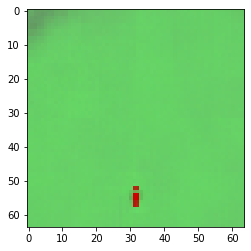

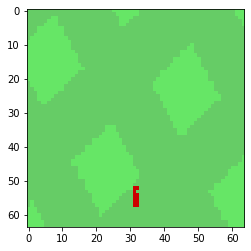

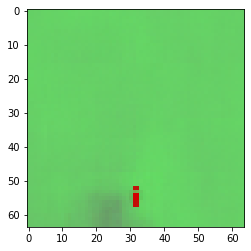

In [ ]:
from PIL import Image
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    X_batch = data.to(device, dtype=torch.float)
    X_prime, mu, logvar = vae(X_batch)
    for i in range(5):
      x_orig = np.transpose(X_batch[i].cpu().numpy(), (1, 2, 0))
      plt.imshow(x_orig)
      plt.show()
      x_recon = np.transpose(X_prime[i].cpu().numpy(), (1, 2, 0))
      plt.imshow(x_recon)
      plt.show()
    break

In [ ]:
model_path =  '/content/drive/MyDrive/vae_nonorm_b8.pt'
torch.save(vae.state_dict(), model_path)
loaded = VAE(device, 250)
loaded.load_state_dict(torch.load(model_path))
loaded.to(device, dtype=torch.float)

In [ ]:
loaded = VAE(device, 250)
loaded.load_state_dict(torch.load(model_path))
loaded.to(device, dtype=torch.float)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
  )
  (mufc): Linear(in_features=1024, out_features=32, bias=True)
  (logvarfc): Linear(in_features=1024, out_features=32, bias=True)
  (decoder_fc): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (7): Sigmoid()
  )
)

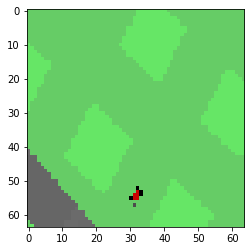

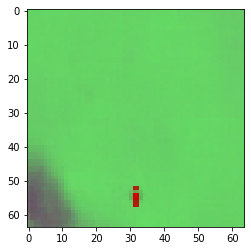

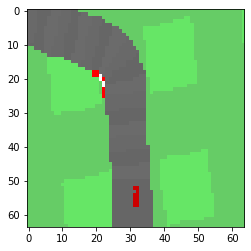

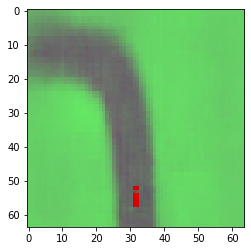

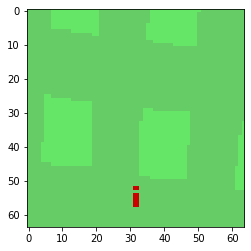

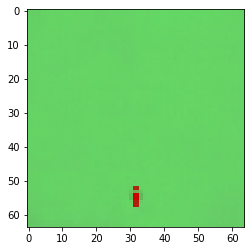

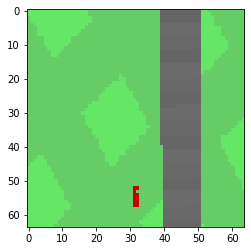

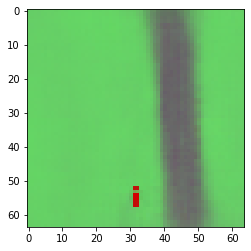

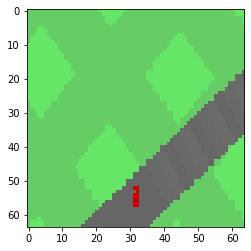

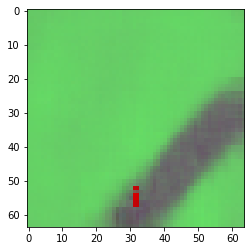

In [ ]:
from PIL import Image
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    X_batch = data.to(device, dtype=torch.float)
    X_prime, mu, logvar = loaded(X_batch)
    for i in range(5):
      x_orig = np.transpose(X_batch[i].cpu().numpy(), (1, 2, 0))
      plt.imshow(x_orig)
      plt.show()
      x_recon = np.transpose(X_prime[i].cpu().numpy(), (1, 2, 0))
      plt.imshow(x_recon)
      plt.show()
    break

In [20]:
path = '/content/drive/MyDrive/env_rollouts/'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), 
                                             torchvision.transforms.Resize((64, 64)), 
                                             torchvision.transforms.ToTensor()])

data_train = RolloutVaeDataset(path, transforms)
trainloader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,shuffle=False)

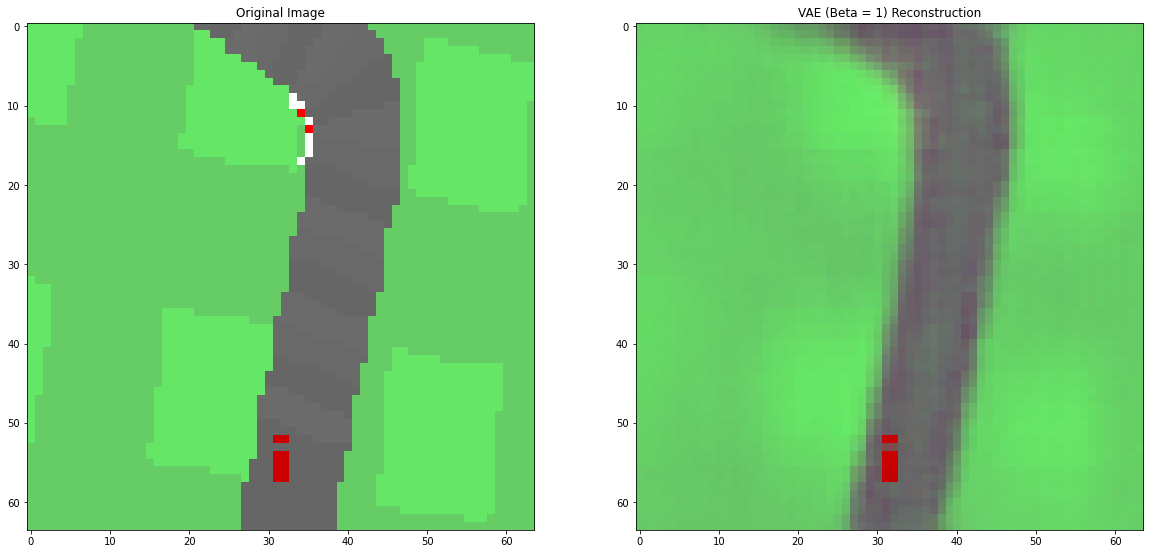

tensor(7129533.)


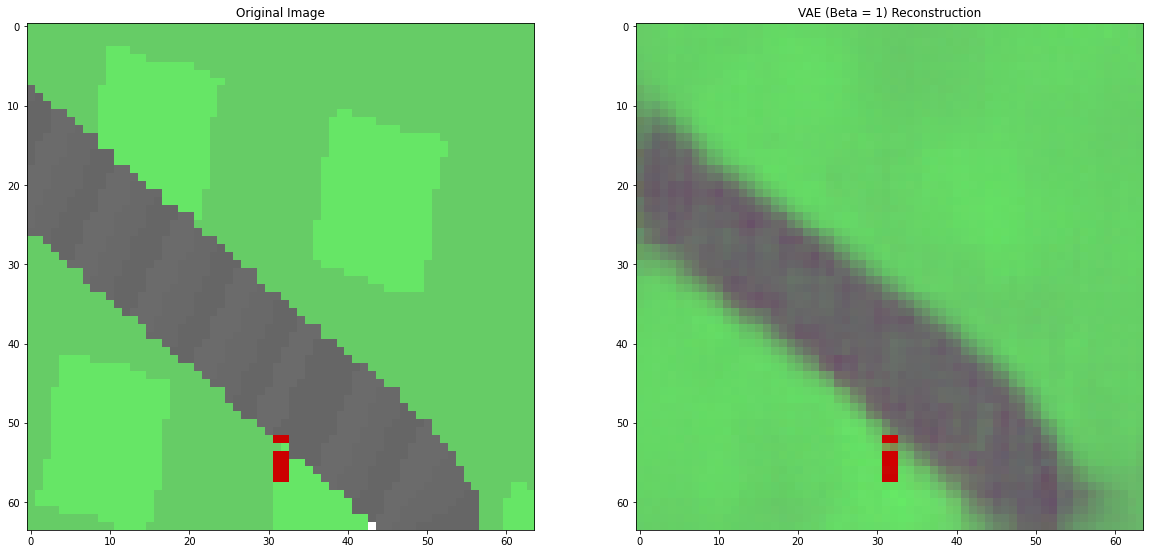

In [36]:
model_path =  '/content/drive/MyDrive/weights/vae_nonorm_b1.pt'
loaded = VAE(device, 250)
loaded.load_state_dict(torch.load(model_path, map_location=device))
loaded.to(device, dtype=torch.float)
from PIL import Image
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    X_batch = data.to(device, dtype=torch.float)
    X_prime, mu, logvar = loaded(X_batch)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    x_orig = np.transpose(X_batch[50].cpu().numpy(), (1, 2, 0))
    ax1.imshow(x_orig)
    x_recon = np.transpose(X_prime[50].cpu().numpy(), (1, 2, 0))
    ax2.imshow(x_recon)
    ax1.set_title('Original Image')
    ax2.set_title('VAE (Beta = 1) Reconstruction')
    plt.show()

    print(nn.BCELoss(reduction='sum')(X_prime, X_batch))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    x_orig = np.transpose(X_batch[100].cpu().numpy(), (1, 2, 0))
    ax1.imshow(x_orig)
    x_recon = np.transpose(X_prime[100].cpu().numpy(), (1, 2, 0))
    ax2.imshow(x_recon)
    ax1.set_title('Original Image')
    ax2.set_title('VAE (Beta = 1) Reconstruction')
    plt.show()
    break

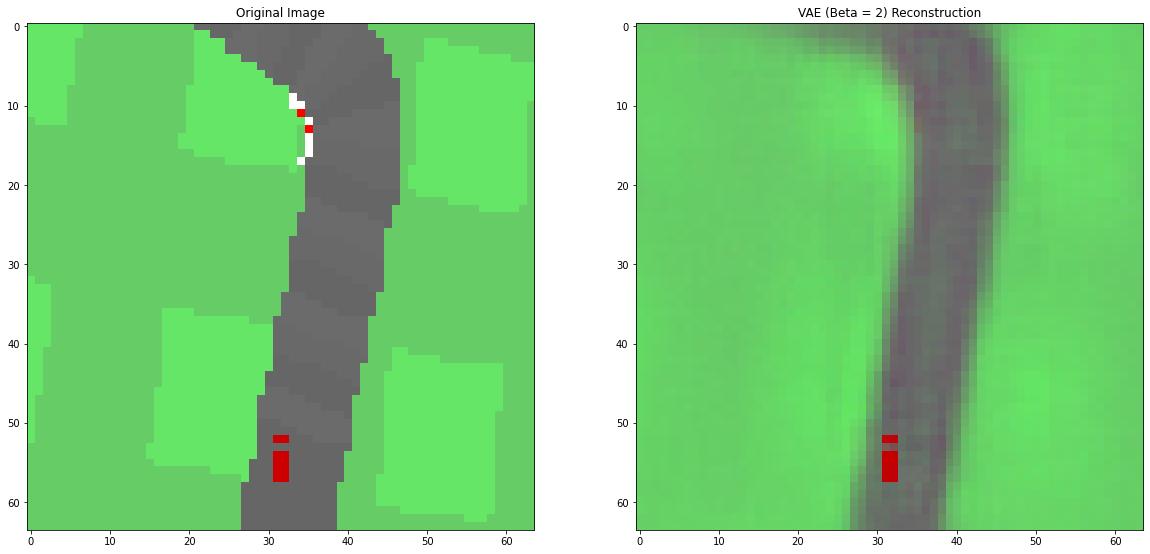

tensor(7145845.5000)


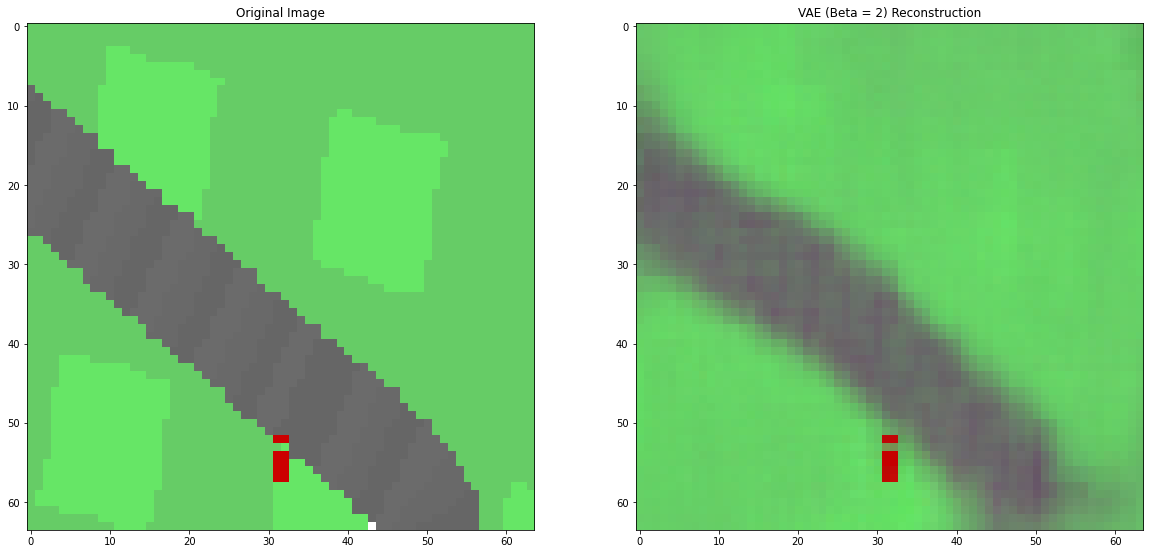

In [37]:
path = '/content/drive/MyDrive/env_rollouts/'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), 
                                             torchvision.transforms.Resize((64, 64)), 
                                             torchvision.transforms.ToTensor()])

data_train = RolloutVaeDataset(path, transforms)
trainloader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,shuffle=False)

model_path =  '/content/drive/MyDrive/weights/vae_nonorm_b2.pt'
loaded = VAE(device, 250)
loaded.load_state_dict(torch.load(model_path, map_location=device))
loaded.to(device, dtype=torch.float)
from PIL import Image
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    X_batch = data.to(device, dtype=torch.float)
    X_prime, mu, logvar = loaded(X_batch)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    x_orig = np.transpose(X_batch[50].cpu().numpy(), (1, 2, 0))
    ax1.imshow(x_orig)
    x_recon = np.transpose(X_prime[50].cpu().numpy(), (1, 2, 0))
    ax2.imshow(x_recon)
    ax1.set_title('Original Image')
    ax2.set_title('VAE (Beta = 2) Reconstruction')
    plt.show()

    print(nn.BCELoss(reduction='sum')(X_prime, X_batch))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    x_orig = np.transpose(X_batch[100].cpu().numpy(), (1, 2, 0))
    ax1.imshow(x_orig)
    x_recon = np.transpose(X_prime[100].cpu().numpy(), (1, 2, 0))
    ax2.imshow(x_recon)
    ax1.set_title('Original Image')
    ax2.set_title('VAE (Beta = 2) Reconstruction')
    plt.show()
    break

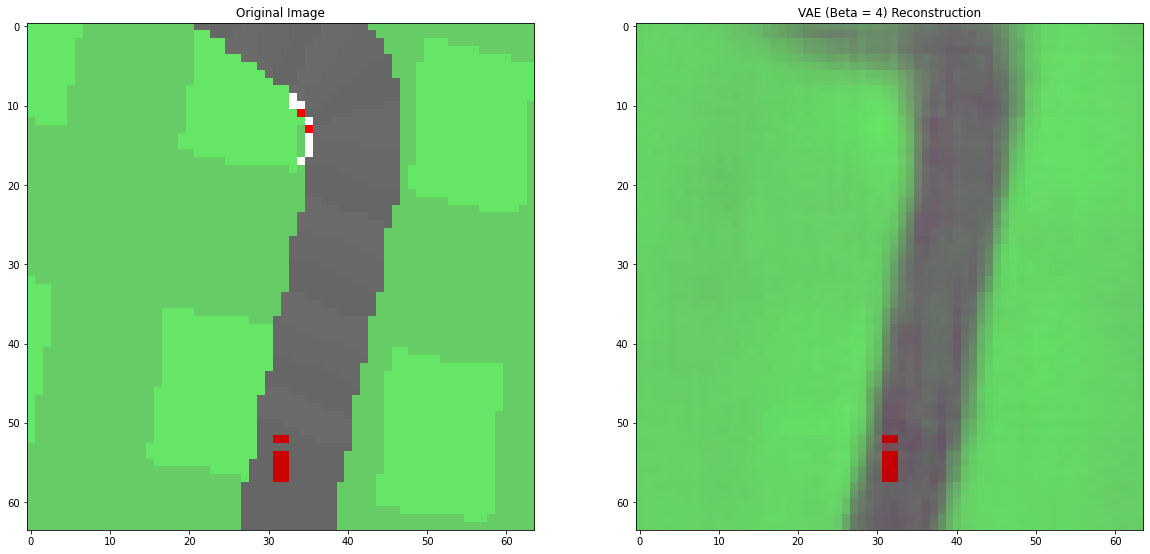

tensor(7152680.5000)


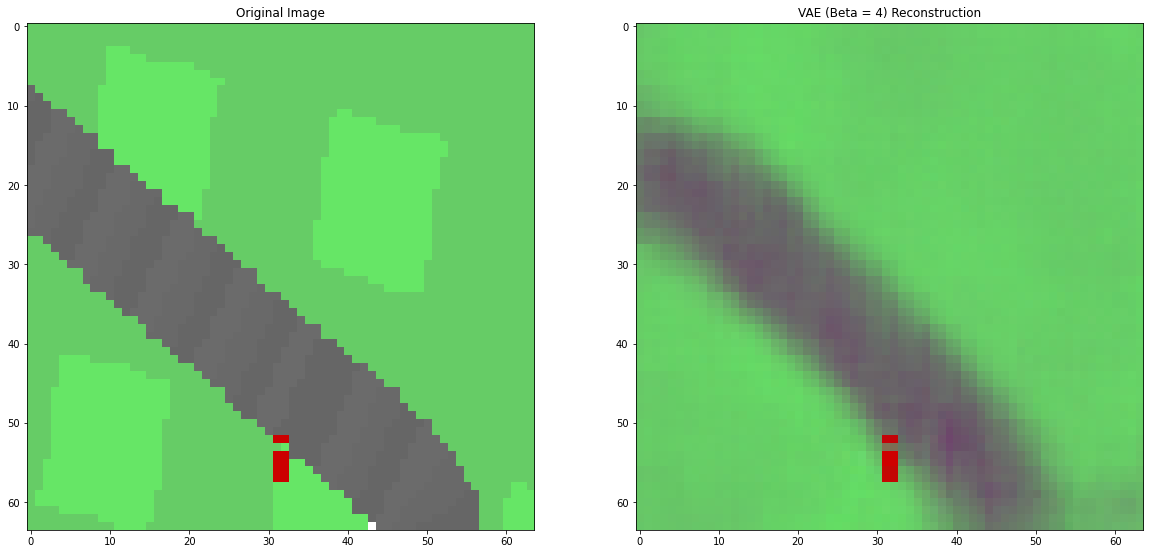

In [38]:
path = '/content/drive/MyDrive/env_rollouts/'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), 
                                             torchvision.transforms.Resize((64, 64)), 
                                             torchvision.transforms.ToTensor()])

data_train = RolloutVaeDataset(path, transforms)
trainloader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,shuffle=False)

model_path =  '/content/drive/MyDrive/weights/vae_nonorm_b4.pt'
loaded = VAE(device, 250)
loaded.load_state_dict(torch.load(model_path, map_location=device))
loaded.to(device, dtype=torch.float)
from PIL import Image
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    X_batch = data.to(device, dtype=torch.float)
    X_prime, mu, logvar = loaded(X_batch)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    x_orig = np.transpose(X_batch[50].cpu().numpy(), (1, 2, 0))
    ax1.imshow(x_orig)
    x_recon = np.transpose(X_prime[50].cpu().numpy(), (1, 2, 0))
    ax2.imshow(x_recon)
    ax1.set_title('Original Image')
    ax2.set_title('VAE (Beta = 4) Reconstruction')
    plt.show()

    print(nn.BCELoss(reduction='sum')(X_prime, X_batch))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    x_orig = np.transpose(X_batch[100].cpu().numpy(), (1, 2, 0))
    ax1.imshow(x_orig)
    x_recon = np.transpose(X_prime[100].cpu().numpy(), (1, 2, 0))
    ax2.imshow(x_recon)
    ax1.set_title('Original Image')
    ax2.set_title('VAE (Beta = 4) Reconstruction')
    plt.show()
    break

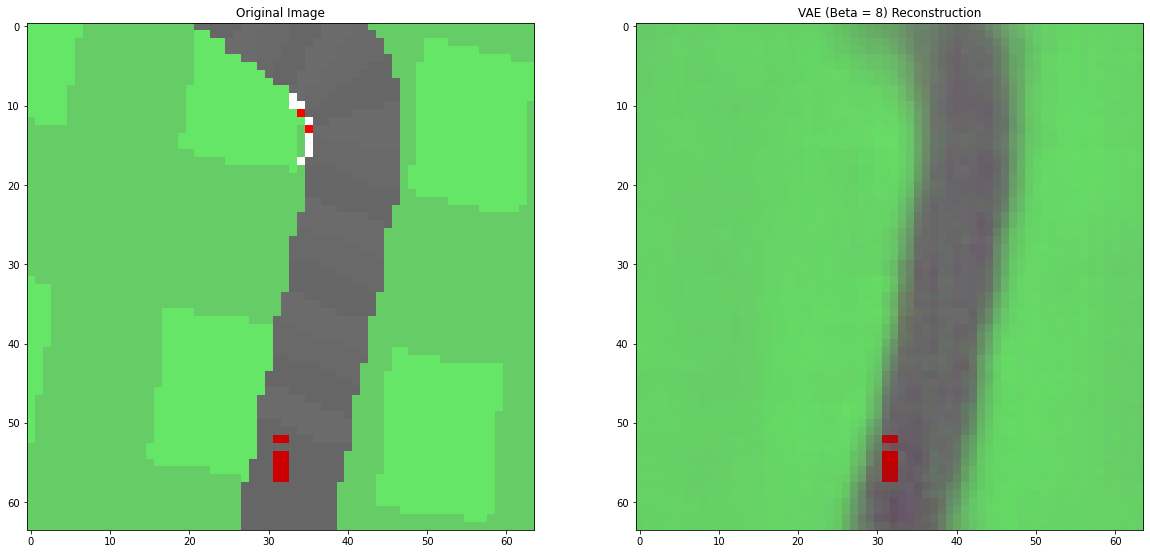

tensor(7165150.5000)


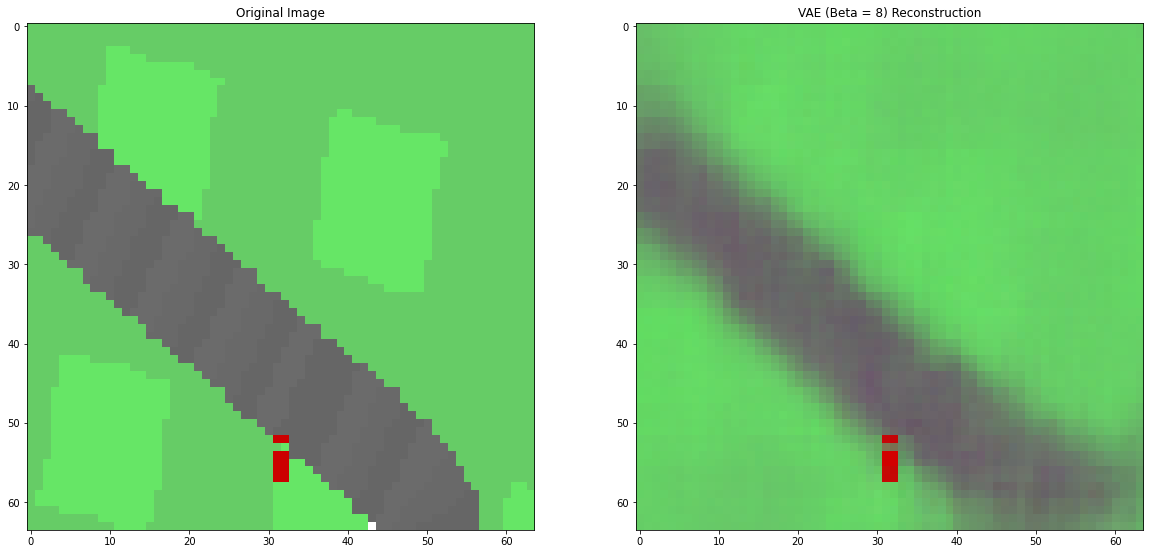

In [39]:
path = '/content/drive/MyDrive/env_rollouts/'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), 
                                             torchvision.transforms.Resize((64, 64)), 
                                             torchvision.transforms.ToTensor()])
data_train = RolloutVaeDataset(path, transforms)
trainloader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,shuffle=False)

model_path =  '/content/drive/MyDrive/weights/vae_nonorm_b8.pt'
loaded = VAE(device, 250)
loaded.load_state_dict(torch.load(model_path, map_location=device))
loaded.to(device, dtype=torch.float)
from PIL import Image
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    X_batch = data.to(device, dtype=torch.float)
    X_prime, mu, logvar = loaded(X_batch)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    x_orig = np.transpose(X_batch[50].cpu().numpy(), (1, 2, 0))
    ax1.imshow(x_orig)
    x_recon = np.transpose(X_prime[50].cpu().numpy(), (1, 2, 0))
    ax2.imshow(x_recon)
    ax1.set_title('Original Image')
    ax2.set_title('VAE (Beta = 8) Reconstruction')
    plt.show()

    print(nn.BCELoss(reduction='sum')(X_prime, X_batch))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    x_orig = np.transpose(X_batch[100].cpu().numpy(), (1, 2, 0))
    ax1.imshow(x_orig)
    x_recon = np.transpose(X_prime[100].cpu().numpy(), (1, 2, 0))
    ax2.imshow(x_recon)
    ax1.set_title('Original Image')
    ax2.set_title('VAE (Beta = 8) Reconstruction')
    plt.show()
    break